In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn import metrics
from sklearn import tree
from sklearn.tree import export_graphviz
from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve, roc_auc_score

import statsmodels.api as sm

In [2]:
pd.set_option("display.max_rows",50)
df=pd.read_csv('Phishing_Legitimate_full.csv')

#koniecznie usuwamy id bo przypisuje do tej kolumny predykcje, anstenie model ma metryki 1
df.drop(['id'],axis=1,inplace=True)

In [3]:
#podział zmiennych w modelu na numeryczne i kateogryczne 
target = 'CLASS_LABEL'
numFeatures = ['NumDots', 'SubdomainLevel', 'PathLevel', 'UrlLength', 'NumDash',
       'NumDashInHostname', 'NumUnderscore','NumPercent', 'NumQueryComponents', 'NumAmpersand',
       'NumNumericChars','HostnameLength', 'PathLength', 'QueryLength',
       'NumSensitiveWords']
catFeatures = ['AtSymbol','TildeSymbol','NumHash', 'NoHttps','RandomString', 'IpAddress','DomainInSubdomains','DomainInPaths','HttpsInHostname',
              'DoubleSlashInPath','EmbeddedBrandName','PctExtHyperlinks','PctExtResourceUrls', 'ExtFavicon', 'InsecureForms',
       'RelativeFormAction', 'ExtFormAction', 'AbnormalFormAction',
       'PctNullSelfRedirectHyperlinks', 'FrequentDomainNameMismatch',
       'FakeLinkInStatusBar', 'RightClickDisabled', 'PopUpWindow',
       'SubmitInfoToEmail', 'IframeOrFrame', 'MissingTitle',
       'ImagesOnlyInForm','ExtMetaScriptLinkRT','UrlLengthRT','SubdomainLevelRT',
       'PctExtResourceUrlsRT', 'AbnormalExtFormActionR',
       'PctExtNullSelfRedirectHyperlinksRT']

In [4]:
features = df.columns.tolist()
features.remove(target)
print(features)

['NumDots', 'SubdomainLevel', 'PathLevel', 'UrlLength', 'NumDash', 'NumDashInHostname', 'AtSymbol', 'TildeSymbol', 'NumUnderscore', 'NumPercent', 'NumQueryComponents', 'NumAmpersand', 'NumHash', 'NumNumericChars', 'NoHttps', 'RandomString', 'IpAddress', 'DomainInSubdomains', 'DomainInPaths', 'HttpsInHostname', 'HostnameLength', 'PathLength', 'QueryLength', 'DoubleSlashInPath', 'NumSensitiveWords', 'EmbeddedBrandName', 'PctExtHyperlinks', 'PctExtResourceUrls', 'ExtFavicon', 'InsecureForms', 'RelativeFormAction', 'ExtFormAction', 'AbnormalFormAction', 'PctNullSelfRedirectHyperlinks', 'FrequentDomainNameMismatch', 'FakeLinkInStatusBar', 'RightClickDisabled', 'PopUpWindow', 'SubmitInfoToEmail', 'IframeOrFrame', 'MissingTitle', 'ImagesOnlyInForm', 'SubdomainLevelRT', 'UrlLengthRT', 'PctExtResourceUrlsRT', 'AbnormalExtFormActionR', 'ExtMetaScriptLinkRT', 'PctExtNullSelfRedirectHyperlinksRT']


In [5]:
#wrapper walidacji krzyżowej dla algorytmu RandomForest
def CVTestRFClass(nFolds = 5, randomState=2020, debug=False, features=features, *args, **kwargs):
    kf = KFold(n_splits=nFolds, shuffle=True, random_state=randomState)
    # listy do przechowywania wyników:
    testResults = []
    trainResults = []
    predictions = []
    indices = []

    # Pętla walidująca model na kolejnych foldach
    for train, test in kf.split(df.index.values):
        # Przygotowanie estymatora
        clf = RandomForestClassifier(*args, **kwargs, random_state=randomState, n_jobs=-1)
        if debug:
            print(clf)
        # Trenowanie modelu
        clf.fit(df.iloc[train][features], df.iloc[train][target])

        # Przygotowanie prognoz dla zbioru treningowego i testowego
        # UWAGA Sklearn zwracał będzie dwie kolumny prawdopodobieństw dla obydwu klas
        predsTrain = clf.predict_proba(df.iloc[train][features])[:,1]
        preds = clf.predict_proba(df.iloc[test][features])[:,1]
        
        # Zachowajmy informacje o predykcjach dla tego foldu
        predictions.append(preds.tolist().copy())
        
        # Razem z indeksami w oryginalnym data frame
        indices.append(df.iloc[test].index.tolist().copy())
        
        # Policzenie dopasowania za pomocą metryki ROC-AUC
        trainScore = roc_auc_score((df[target].iloc[train]==1), predsTrain)
        testScore = roc_auc_score((df[target].iloc[test]==1), preds)
        
        # Zapisanie wyników do listy 
        trainResults.append(trainScore)
        testResults.append(testScore)
        
        # Informowanie o każdym foldzie razem z wynikami treningowymi możemy opcjonalnie wyświetlać w trakcie
        if debug:
            print("Train AUC:", trainScore,
                  "Valid AUC:", testScore)
        
    return trainResults, testResults, predictions, indices

In [6]:
#wyniki trenowania modelu RF dla podstawowych wartości hiperparametrów (w tym GINI)
trainResults, testResults, predictions, indices = CVTestRFClass(debug=True)
print(np.mean(testResults))

RandomForestClassifier(n_jobs=-1, random_state=2020)
Train AUC: 1.0 Valid AUC: 0.999114968138853
RandomForestClassifier(n_jobs=-1, random_state=2020)
Train AUC: 1.0 Valid AUC: 0.9983551166531053
RandomForestClassifier(n_jobs=-1, random_state=2020)
Train AUC: 1.0 Valid AUC: 0.998822904655277
RandomForestClassifier(n_jobs=-1, random_state=2020)
Train AUC: 1.0 Valid AUC: 0.9979521965570866
RandomForestClassifier(n_jobs=-1, random_state=2020)
Train AUC: 1.0 Valid AUC: 0.998390459761494
0.9985271291531632


In [7]:
#szukanie optymalnej ilości drzew decyzyjnych
for k in [10, 25, 50, 100, 200, 500, 1000]:
    trainResults, testResults, predictions, indices = CVTestRFClass(n_estimators=k)
    print(k, np.mean(trainResults), np.mean(testResults), np.mean(trainResults) - np.mean(testResults))
#50 najlepsze

10 0.9999951874588309 0.9973558727862976 0.0026393146725333105
25 0.999999843749302 0.9982515345799383 0.0017483091693636377
50 1.0 0.9983760303935728 0.0016239696064271891
100 1.0 0.9985271291531632 0.0014728708468367824
200 1.0 0.9985503119453281 0.0014496880546719382
500 1.0 0.9985824468898125 0.0014175531101875416
1000 1.0 0.9985484317746369 0.0014515682253630757


In [8]:
# n_estimator = 50, teraz szukamy maksymalnej głębokości pojedyńczego drzewa 
for k in range(2,22,2):
    trainResults, testResults, predictions, indices = CVTestRFClass(n_estimators=50, max_depth=k)
    print(k, np.mean(trainResults), np.mean(testResults), np.mean(trainResults) - np.mean(testResults))
#max_depth = 20, wtedy najlepszy wynik

2 0.984854058384775 0.98455991380173 0.00029414458304499735
4 0.9923551927727623 0.9917461182009527 0.0006090745718095869
6 0.9957059914350609 0.9941716851616993 0.0015343062733615964
8 0.9982086225383553 0.996485744788702 0.0017228777496532954
10 0.9993796327446341 0.9975133628795767 0.001866269865057446
12 0.9998242579137715 0.9980038436400596 0.0018204142737119344
14 0.9999647866781392 0.998234042120114 0.0017307445580251324
16 0.9999940998170018 0.9983176655953448 0.001676434221656975
18 0.9999996499977841 0.9982512302954646 0.001748419702319537
20 0.9999999874999805 0.9983977814246726 0.0016022060753079215


In [10]:
# n_estimator = 50 i max_depth = 20, teraz szukamy ilości zmiennych branych pod uwagę przy podziale węzła
for k in range(2, len(features) + 1,2):
    trainResults, testResults, predictions, indices = CVTestRFClass(n_estimators=50, max_depth=20,
                                                                    max_features=k)
    print(k, np.mean(trainResults), np.mean(testResults), np.mean(trainResults) - np.mean(testResults))
# najlepszy wynik dla 4

2 0.9999978749434257 0.998175154581267 0.0018227203621586918
4 0.9999997374987359 0.998422902855945 0.001576834642790903
6 0.9999999874999805 0.9983978815088432 0.0016021059911373037
8 1.0 0.9982240369896245 0.0017759630103755253
10 0.9999999749993147 0.9979820665995023 0.002017908399812418
12 1.0 0.9980119992166037 0.0019880007833963376
14 0.9999999937496714 0.9977895854040788 0.002210408345592607
16 0.9999999874993429 0.997554758264906 0.0024452292344369075
18 0.999999987499972 0.9974115633462951 0.0025884241536768826
20 0.9999999624986579 0.997390002924992 0.002609959573665832
22 0.9999999312463862 0.9974724096354605 0.0025275216109257315
24 0.9999999749986859 0.9974153748600669 0.002584600138618942
26 0.9999999562477002 0.9971731092057359 0.002826847041964342
28 0.9999999312463862 0.9973885331046839 0.0026113981417023036
30 0.9999999624980287 0.9972896864878861 0.0027102760101426204
32 0.9999999374967146 0.9968243187746376 0.003175618722076945
34 0.9999999187460435 0.99683749056264

In [15]:
# n_estimator = 50 i max_depth = 20 i max_features = 4, teraz szukamy minimalne ilości danych w węźle przed podziałem
for k in [2, 4, 6, 8, 10, 15, 20, 30]:
    trainResults, testResults, predictions, indices = CVTestRFClass(n_estimators=50, max_depth=20,
                                                                    max_features=4,
                                                                    min_samples_split=k)
    print(k, np.mean(testResults))
# dla 4 najlepszy wynik

2 0.998422902855945
4 0.9984470930058261
6 0.9982009889969963
8 0.9981606246447058
10 0.9980452557100413
15 0.9978070097872942
20 0.9977579337515834
30 0.9974476774172165


In [16]:
# n_estimator = 50 i max_depth = 20 i max_features = 4 i min_samples_split = 4, teraz minimalna ilość danych w węźle końcowym
for k in [1, 2, 4]:
    trainResults, testResults, predictions, indices = CVTestRFClass(n_estimators=50, max_depth=20,
                                                                    max_features=4,
                                                                    min_samples_split=4, min_samples_leaf=k)
    print(k, np.mean(testResults))
# dla 1 

1 0.9984470930058261
2 0.9980979214373603
4 0.9975237603198375


In [18]:
#najlepszy model RandomForest z dobranymi hiperparametrami
trainResults, testResults, predictions, indices = CVTestRFClass(n_estimators=50, max_depth=20,
                                                                    max_features=4,
                                                                    min_samples_split=4, min_samples_leaf=1)
print(np.mean(trainResults), np.mean(testResults))

modelRF = {
    "name":"RF",
    "description":"Model RF, ze zmiennymi kategorycznymi z LE",
    "specification":'n_estimators=50, max_depth=20, max_features=4, min_samples_split=4, min_samples_leaf=1',
    "trainResults":trainResults.copy(),
    "testResults":testResults.copy(),
    "predictions":predictions.copy(),
    "indices":indices.copy(),
}

0.9999925873108368 0.9984470930058261


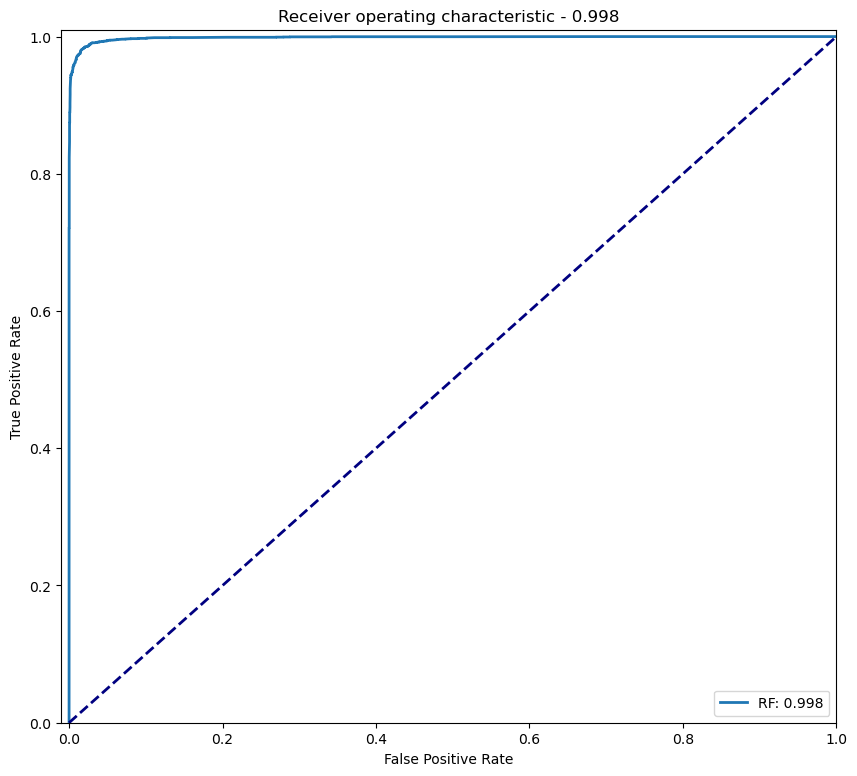

In [14]:
def plotROCs(results):
    ''' Funkcja, do rysowania szeregu wyników krzywych ROC dla poszczególnych eksperymentów
    results - lista wyników jako 3 elementowe tuple (true, pred, label)
    '''

    # Ustalanie wielkości rysunku
    fig, ax = plt.subplots(figsize=(10,9))

    for true, pred, label in results:
        # Obliczenie punktów potrzebnych do narysowani akrzywej ROC
        # funkcja roc_curve zwarca trzy serie danych, fpr, tpr oraz poziomy progów odcięcia
        fpr, tpr, thresholds = roc_curve(true, pred)
        # Obliczamy pole powierzchni pod krzywą
        rocScore = roc_auc_score(true, pred)
        rocScore = round(rocScore, 3)

        # Grubość krzywej
        lw = 2

        # Rysujemy krzywą ROC
        ax.plot(fpr, tpr, lw=lw, label=f'{label}: {rocScore}')
    # Rysujemy krzywą 45 stopni jako punkt odniesienia
    ax.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    # Dodajemy lekkie marginesy do zakresu aby krzywa nie pokrywała się z osiami
    ax.set_xlim([-0.01, 1.0])
    ax.set_ylim([0.0, 1.01])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'Receiver operating characteristic - {rocScore}')
    ax.legend(loc="lower right")
    plt.show()

res2plot = []
true = (df[target]==1).sort_index()
pred = pd.Series(sum(modelRF["predictions"], []), index=sum(modelRF["indices"], [])).sort_index()
res2plot.append((true, pred, modelRF["name"]))

plotROCs(res2plot)